In [81]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from IPython.display import Image
DEBUG = True

In [82]:
def decompose_circuit(circuit):
    
    dag = qiskit.converters.circuit_to_dag(circuit)
    
    if DEBUG:
        print("circuit:", type(circuit))
        print("dag:", type(dag))
        print("dag global_phase:", dag.global_phase)
        print("dag nodes:", dag.node_counter)
        print("dag qubits:", len(dag.qubits), dag.qubits)
        image = dag.draw()
        print("image:", type(image))
        display(dag.draw())
        print("dag: props", dag.properties())
        print("dag mq_ops:", dag.multi_qubit_ops())
    
    decomposed_circuit_dag = qiskit.transpiler.passes.Unroll3qOrMore().run(dag)

    decomposed_circuit = qiskit.converters.dag_to_circuit(decomposed_circuit_dag)    
    
    if DEBUG: 
        print("dc dag: ", type(decomposed_circuit_dag))
        print("dc_dag props:", decomposed_circuit_dag.properties())
        print("dc_dag mq_ops:", decomposed_circuit_dag.multi_qubit_ops())
        display(decomposed_circuit_dag.draw())    
        print("dc:", type(decomposed_circuit))
        print(decomposed_circuit.draw())
        
    return decomposed_circuit

def adapt_circuit(circuit, new_reg, connection_graph_nx, connection_graph_dictionary):
    new_c = QuantumCircuit(new_reg)
    
    decomposed_circuit  = decompose_circuit(circuit)
    
    return new_c

       ┌───┐                         
q52_0: ┤ H ├──■──────────────────────
       └───┘  │                      
q52_1: ───────┼────■─────────────────
            ┌─┴─┐┌─┴─┐┌───┐┌───┐     
q52_2: ─────┤ X ├┤ X ├┤ H ├┤ X ├──■──
            └───┘└───┘└───┘└─┬─┘  │  
q52_3: ──────────────────────■────■──
                                ┌─┴─┐
q52_4: ─────────────────────────┤ X ├
                                └───┘
q52_5: ──────────────────────────────
                                     
g: <class 'networkx.classes.graph.Graph'>
circuit: <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
dag: <class 'qiskit.dagcircuit.dagcircuit.DAGCircuit'>
dag global_phase: 0
dag nodes: 18
dag qubits: 6 [Qubit(QuantumRegister(6, 'q52'), 0), Qubit(QuantumRegister(6, 'q52'), 1), Qubit(QuantumRegister(6, 'q52'), 2), Qubit(QuantumRegister(6, 'q52'), 3), Qubit(QuantumRegister(6, 'q52'), 4), Qubit(QuantumRegister(6, 'q52'), 5)]
image: <class 'PIL.PngImagePlugin.PngImageFile'>


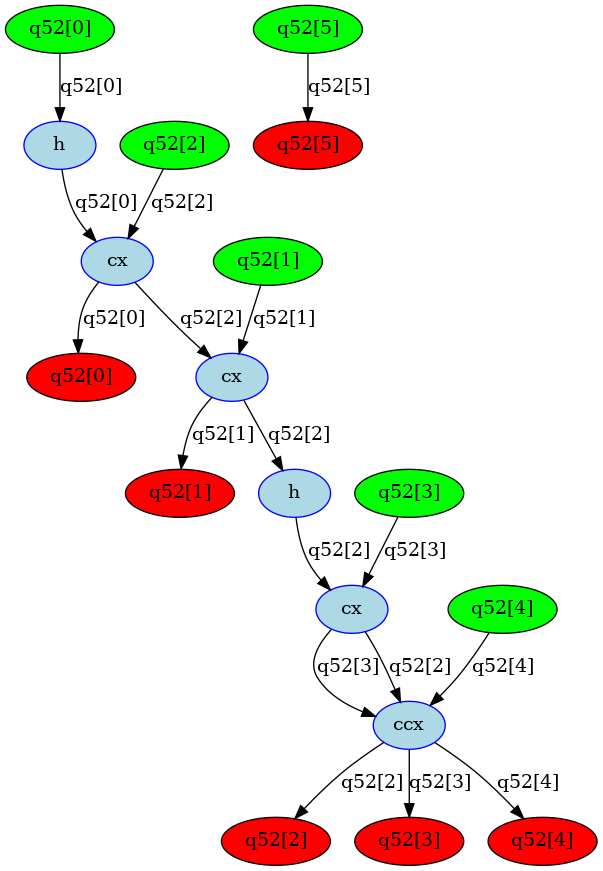

dag: props {'size': 6, 'depth': 6, 'width': 6, 'qubits': 6, 'bits': 0, 'factors': 2, 'operations': {'h': 2, 'cx': 3, 'ccx': 1}}
dag mq_ops: [<qiskit.dagcircuit.dagnode.DAGNode object at 0x7f8221fd02e0>]
dc dag:  <class 'qiskit.dagcircuit.dagcircuit.DAGCircuit'>
dc_dag props: {'size': 20, 'depth': 15, 'width': 6, 'qubits': 6, 'bits': 0, 'factors': 2, 'operations': {'h': 4, 'cx': 9, 'tdg': 3, 't': 4}}
dc_dag mq_ops: []


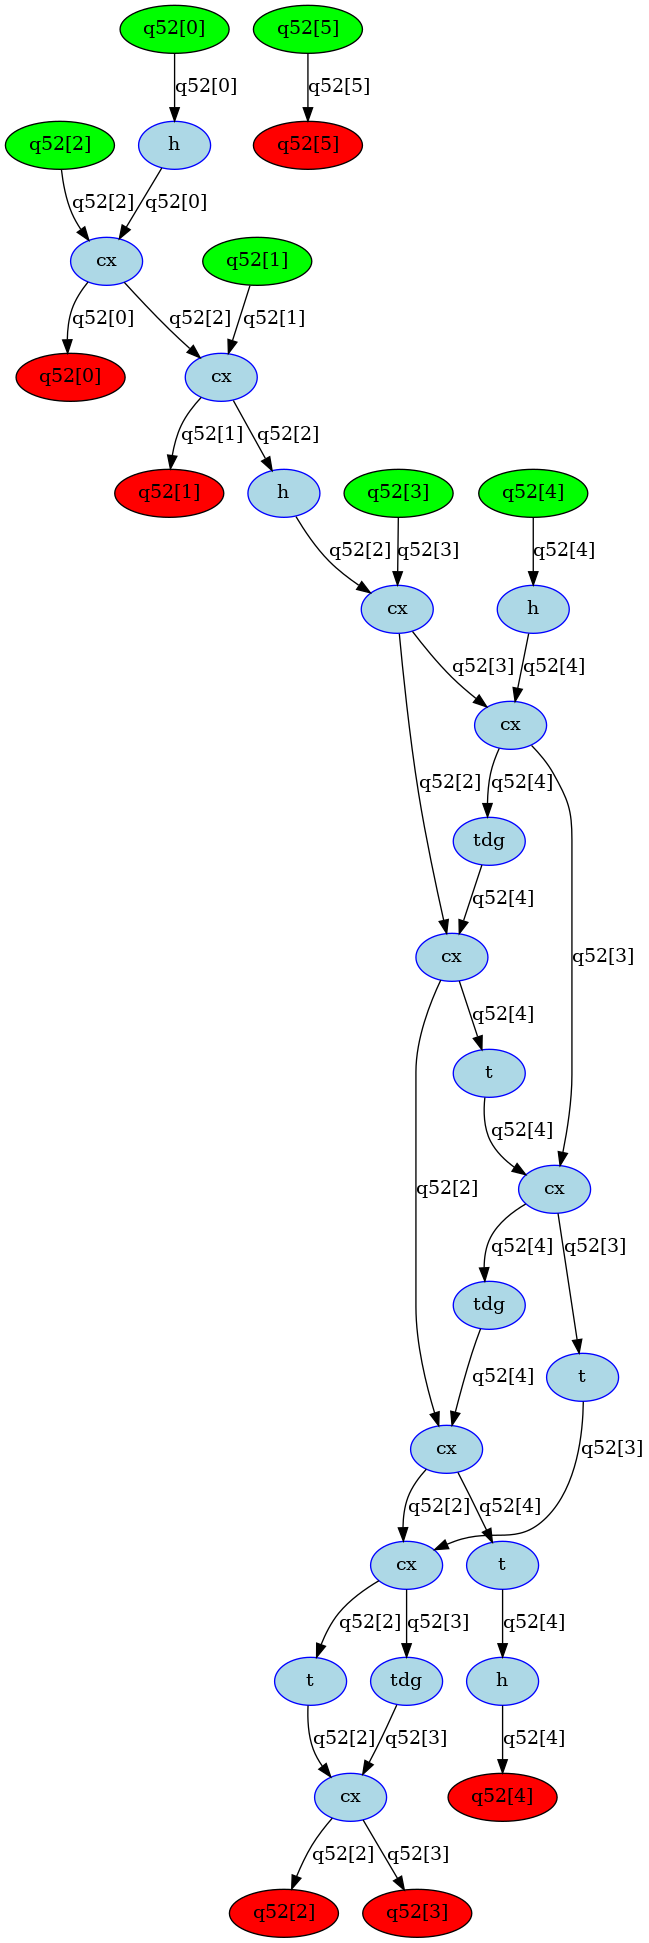

dc: <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
       ┌───┐                                                                »
q52_0: ┤ H ├──■─────────────────────────────────────────────────────────────»
       └───┘  │                                                             »
q52_1: ───────┼────■────────────────────────────────────────────────────────»
            ┌─┴─┐┌─┴─┐┌───┐┌───┐                                            »
q52_2: ─────┤ X ├┤ X ├┤ H ├┤ X ├──────────────■─────────────────────■────■──»
            └───┘└───┘└───┘└─┬─┘              │             ┌───┐   │  ┌─┴─┐»
q52_3: ──────────────────────■────■───────────┼─────────■───┤ T ├───┼──┤ X ├»
       ┌───┐                    ┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤»
q52_4: ┤ H ├────────────────────┤ X ├┤ TDG ├┤ X ├┤ T ├┤ X ├┤ TDG ├┤ X ├┤ T ├»
       └───┘                    └───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘»
q52_5: ─────────────────────────────────────────────────────────────────────»
     

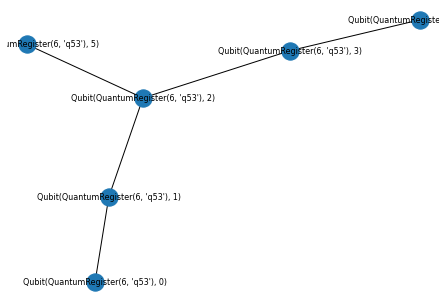

In [83]:
# Simple Example
old_reg = QuantumRegister(6)
c = QuantumCircuit(old_reg)
i = 2
for j in range(0, 4):
    if random.random() < 0.75:
        c.h(j)
    if i == j:
        continue
    c.cx(j, i)
c.ccx(2, 3, 4)

print(c.draw())

reg = QuantumRegister(6)
d = {}
for q in reg:
    d[q] = [] 
    
g = nx.Graph()

print("g:", type(g))

g.add_edge(reg[0], reg[1])
d[reg[0]].append(reg[1])
d[reg[1]].append(reg[0])
g.add_edge(reg[1], reg[2])
d[reg[1]].append(reg[2])
d[reg[2]].append(reg[1])
g.add_edge(reg[2], reg[5])
d[reg[2]].append(reg[5])
d[reg[5]].append(reg[2])
g.add_edge(reg[2], reg[3])
d[reg[2]].append(reg[3])
d[reg[3]].append(reg[2])
g.add_edge(reg[3], reg[4])
d[reg[3]].append(reg[4])
d[reg[4]].append(reg[3])

nx.draw(g, with_labels=True, font_size=8)

new_c = adapt_circuit(c, reg, g, d)

print(new_c.draw())